In [1]:
import numpy as np
import cvxpy as cp
import sympy as sym
import pandas as pd
import cvxpy as cp
import tensorflow as tf
import torch 
from cvxpylayers.tensorflow import CvxpyLayer
# from sklearn import preprocessing
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.colors as mcolors

%run Functs.ipynb
%run GSSP.ipynb
%run PGMB.ipynb

### Compare Portfolios

**Aproaches:**<br>
**(1)** Equaly weighed portfolio: $${w}_{opt} = {w}_{ew} = \frac{1}{N}1$$

**(2)** Least squares problem(solved using cvxpy): $${w}_{opt} = \textrm{arg min} \lVert Xw - r^{*} 1 \lVert^{2}_{2}$$

**(3)** Lasso problem(solved using cvxpy): $${w}_{opt} = \textrm{arg min} \lVert Xw - r^{*} 1 \lVert^{2}_{2} +\lambda\lVert w \lVert_{1}$$

**(4-5)** Sparse-Convex approach. Find a k-sparse portfolio wk that
replicates performance of the (very non-sparse) equally weighted
portfolio $w_{ew}$ . Amounts to solving: $${w}_{opt} = \textrm{arg min} \lVert Xw - Xw_{ew} \lVert^{2}_{2}$$
Solved using Gradient Descent (solutions 3 and 4 are for k=5 and k=10 respectively).
<br>
<br>
**Constraints of every problem:** $$\quad w^{\top}\hat{\mu}=r^{*} $$
                              $$w^{\top}=1 $$
                              $$w_{i}\geq{0} $$


In [5]:
def loss_fn(X, Y, w):
    return cp.norm2(X @ w - Y)**2

def regularizer(w):
    return cp.norm1(w)

def objective_fn(X, Y, w, lambd):
    return loss_fn(X, Y, w) + lambd * regularizer(w)

In [6]:
train_data = pd.read_csv(r'data.csv', header=None)
train_data.columns=np.arange(train_data.shape[1])

In [7]:
RR = train_data/100
numportfolios = 9
MonthlyReturns = np.zeros((numportfolios,360));
AnnualReturns = np.zeros((numportfolios,30));
rho = 0.1/12; # `annualised' return of 10%
y = rho*np.ones(60);

In [18]:
for i in range (60,409,12):
    portfolios = np.zeros((numportfolios,train_data.shape[1]));
    Phi = RR[i-60:i]
    
    #equally weighted portfolio
#     portfolios[0] = np.ones(48)/48
    
    #CVX least squares   
    w = cp.Variable(48, nonneg=True)
    least_squares_cost = cp.sum_squares(Phi.to_numpy()[0] @ w - y)
    least_squares_prob = cp.Problem(cp.Minimize(
                                    objective_fn(Phi.to_numpy()[0], y, w, 0)),
                                    [cp.sum(w) == 1,])
    
    least_squares_prob.solve()
    portfolios[1] = (w.value)
#     CVX Lasso  
        
#     w = cp.Variable(48)
#     lambd = cp.Parameter(nonneg=True)
#     problem = cp.Problem(cp.Minimize(
#                         objective_fn(Phi.to_numpy()[0], y, w, lambd)),
#                          [cp.sum(w) == 1,])

#     lambd_values = np.logspace(-2, 3, 50)
#     w_values = []
#     for v in lambd_values:
#         lambd.value = v
#         problem.solve(solver=cp.SCS)
#         w_values.append(w.value)
#     portfolios[2] = w.value
#     if i == 60:
#             break
    # sparse-convex
#     w_ew = np.dot(Phi,np.ones((48,1)))/48
#     # k=5
#     x0=np.zeros((48,1))
#     x0[0] = 1/2
#     x0[1] = 1/2
#     w = PGMB(x0,0.1,1,0.25,0.001, 200, Phi, w_ew, 5)
#     portfolios[3] = w.T
    
#     # k=10
#     x0=np.zeros((48,1))
#     x0[0] = 1/2
#     x0[1] = 1/2
#     w = PGMB(x0,0.1,1,0.25,0.001, 200, Phi, w_ew, 10)
#     portfolios[4] = w.T
#     AnnualReturns[4][i//12 - 5] = sum(np.dot(RR[i:i+12],portfolios[4]))
#     MonthlyReturns[4][i-60:i-48] = np.dot(RR[i:i+12],portfolios[4])
    
# CVX-layers
    #Least Squares
    w = cp.Variable((48),nonneg=True)
    constraints = [cp.sum(w) == 1, w>=0]
    ls_prob = cp.Problem(cp.Minimize(
                                    objective_fn(Phi.to_numpy()[0], y, w, 0)),
                                    [cp.sum(w) == 1,])
    assert ls_prob.is_dpp()
    cvxpylayer = CvxpyLayer(ls_prob, parameters=[], variables=[w])
    A_tch = torch.randn(60, 48, requires_grad=True)
    b_tch = torch.randn(60, requires_grad=True)
    solution, = cvxpylayer()
    portfolios[5] = solution.numpy()

#     #Lasso
#     w = cp.Variable((48),nonneg=True)
#     constraints = [cp.sum(w) == 1, w>=0]
    
#     lasso_cost = cp.sum_squares(Phi.to_numpy()[0] @ w - y) + cp.norm1(w)
#     lasso_prob = cp.Problem(cp.Minimize(lasso_cost), constraints)
#     assert prob.is_dpp()
#     cvxpylayer = CvxpyLayer(lasso_prob, parameters=[], variables=[w])
#     A_tch = torch.randn(60, 48, requires_grad=True)
#     b_tch = torch.randn(60, requires_grad=True)
#     solution, = cvxpylayer()
#     portfolios[6] = solution.numpy()
    
#     #ew_replication
#     w = cp.Variable((48))
#     A = cp.Parameter((60, 48))
#     A.value = Phi.to_numpy()
#     W_EW = cp.Parameter((60))
#     W_EW.value = np.dot(Phi,np.ones((48)))/48
    
#     cost = cp.sum_squares(A @ w - W_EW)
#     prob = cp.Problem(
#                         cp.Minimize(cost),
#                         [cp.sum(w) == 1,
#                         w >= 0,]
#                         )

#     assert prob.is_dpp()

#     cvxpylayer = CvxpyLayer(prob, parameters=[A,W_EW], variables=[w])
#     A_tf = tf.Variable(tf.random.normal((60, 48)))
#     b_tf = tf.Variable(tf.random.normal((60,)))
#     solution, = cvxpylayer(A_tf, b_tf)
#     portfolios[7] = solution.numpy()
    
#     #ew_replication sparse
#     w = cp.Variable((48))
#     A = cp.Parameter((60, 48))
#     A.value = Phi.to_numpy()
#     W_EW = cp.Parameter((60))
#     W_EW.value = np.dot(Phi,np.ones((48)))/48
    
#     cost = cp.sum_squares(A @ w - W_EW) + cp.norm1(w)
#     prob = cp.Problem(
#                         cp.Minimize(cost),
#                         [cp.sum(w) == 1,
#                         w >= 0,]
#                         )

#     assert prob.is_dpp()

#     cvxpylayer = CvxpyLayer(prob, parameters=[A,W_EW], variables=[w])
#     A_tf = tf.Variable(tf.random.normal((60, 48)))
#     b_tf = tf.Variable(tf.random.normal((60,)))
#     solution, = cvxpylayer(A_tf, b_tf)
#     portfolios[8] = solution.numpy()
#calculate returns
    for x in range (len(portfolios)):
        AnnualReturns[x][i//12 - 5] = sum(np.dot(RR[i:i+12],portfolios[x]))
        MonthlyReturns[x][i-60:i-48] = np.dot(RR[i:i+12],portfolios[x])

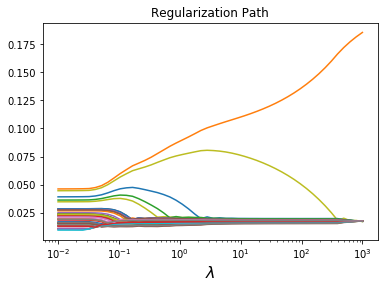

In [19]:
def plot_regularization_path(lambd_values, w_values):
    num_coeffs = len(w_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in w_values])
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.xscale("log")
    plt.title("Regularization Path")
    plt.show()

plot_regularization_path(lambd_values, w_values)

In [20]:
# Calculate the cumulative returns
CumulativeReturns = np.zeros(MonthlyReturns.shape)
for j in range(numportfolios):
    CumulativeReturns[j] = np.cumsum(MonthlyReturns[j])
CumulativeReturns

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04550063, 0.0370802 , 0.02336412, ..., 3.80584531, 3.82197799,
        3.78983228],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

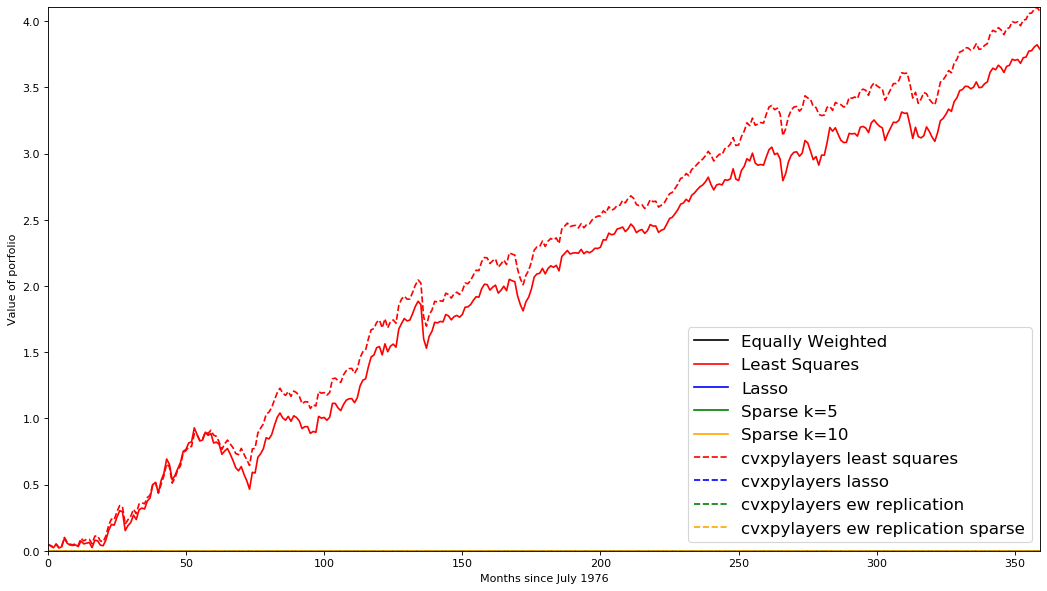

In [21]:
figure(num=None, figsize=(16, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(CumulativeReturns[0],color='black')
plt.plot(CumulativeReturns[1],color='red')
plt.plot(CumulativeReturns[2],color='blue')
plt.plot(CumulativeReturns[3],color='green')
plt.plot(CumulativeReturns[4],color='orange')
plt.plot(CumulativeReturns[5],color='red', linestyle='dashed')
plt.plot(CumulativeReturns[6],color='blue', linestyle='dashed')
plt.plot(CumulativeReturns[7],color='green', linestyle='dashed')
plt.plot(CumulativeReturns[8],color='orange', linestyle='dashed')


plt.margins(0)

legend = ['Equally Weighted', 'Least Squares','Lasso', 'Sparse k=5', 'Sparse k=10','cvxpylayers least squares', 'cvxpylayers lasso','cvxpylayers ew replication','cvxpylayers ew replication sparse']
plt.legend(legend ,loc = "lower right",prop={'size': 15})
plt.xlabel('Months since July 1976')
plt.ylabel('Value of porfolio')

plt.show()

### Final Portfolio Values


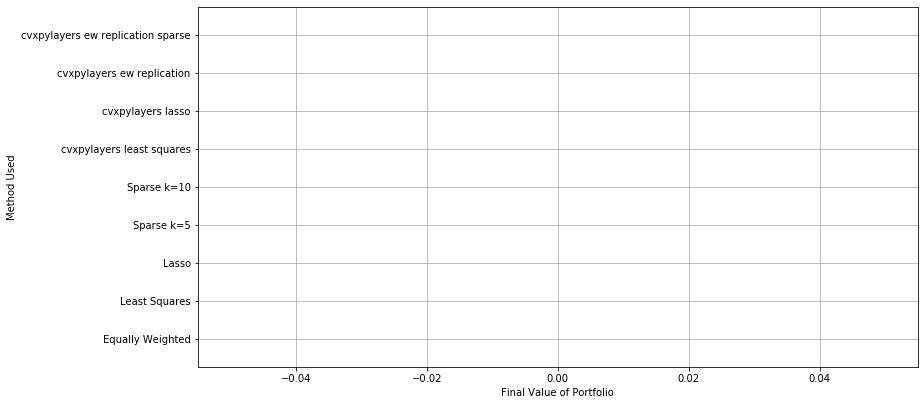

In [9]:
fig = plt.figure(figsize=(10, 5))
fig.set_facecolor("w")

ax = fig.add_axes([0,0,1,1])
Final_Returns = CumulativeReturns[:,359]

Sorted_Final_Returns = np.zeros(numportfolios)
Sorted_Legend = np.empty(numportfolios, dtype="S50")
Sorted_Final_Returns_Indexes = np.argsort(Final_Returns)

for x in range(numportfolios):
    Sorted_Final_Returns[x] = Final_Returns[Sorted_Final_Returns_Indexes[x]]
    Sorted_Legend[x] = legend[Sorted_Final_Returns_Indexes[x]]

ax.barh(Sorted_Legend,Sorted_Final_Returns, align='center',height=0.6, color='cadetblue', zorder=3)
ax.grid(zorder=0)

plt.xlabel('Final Value of Portfolio')
plt.ylabel('Method Used')
plt.show()

###  Average Annual Returns

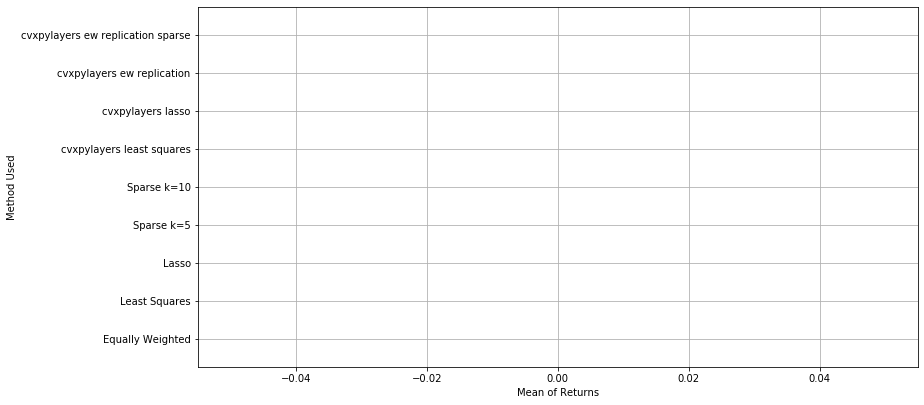

In [10]:
fig = plt.figure(figsize=(10, 5))
fig.set_facecolor("w")

ax = fig.add_axes([0,0,1,1])
Average_Returns = np.zeros(numportfolios)
for x in range(len(Average_Returns)):
    Average_Returns[x] = np.mean(AnnualReturns[x])

Sorted_Average_Returns = np.zeros(numportfolios)
Sorted_Legend = np.empty(numportfolios, dtype="S50")
Sorted_Average_Returns_Indexes = np.argsort(Average_Returns)

for x in range(len(Average_Returns)):
    Sorted_Average_Returns[x] = Average_Returns[Sorted_Average_Returns_Indexes[x]]
    Sorted_Legend[x] = legend[Sorted_Average_Returns_Indexes[x]]

ax.barh(Sorted_Legend,Sorted_Average_Returns, align='center',height=0.6, color='steelblue', zorder=3)
ax.grid(zorder=0)

plt.xlabel('Mean of Returns')
plt.ylabel('Method Used')
plt.show()

In [11]:
lambd_values

array([1.00000000e-02, 1.26485522e-02, 1.59985872e-02, 2.02358965e-02,
       2.55954792e-02, 3.23745754e-02, 4.09491506e-02, 5.17947468e-02,
       6.55128557e-02, 8.28642773e-02, 1.04811313e-01, 1.32571137e-01,
       1.67683294e-01, 2.12095089e-01, 2.68269580e-01, 3.39322177e-01,
       4.29193426e-01, 5.42867544e-01, 6.86648845e-01, 8.68511374e-01,
       1.09854114e+00, 1.38949549e+00, 1.75751062e+00, 2.22299648e+00,
       2.81176870e+00, 3.55648031e+00, 4.49843267e+00, 5.68986603e+00,
       7.19685673e+00, 9.10298178e+00, 1.15139540e+01, 1.45634848e+01,
       1.84206997e+01, 2.32995181e+01, 2.94705170e+01, 3.72759372e+01,
       4.71486636e+01, 5.96362332e+01, 7.54312006e+01, 9.54095476e+01,
       1.20679264e+02, 1.52641797e+02, 1.93069773e+02, 2.44205309e+02,
       3.08884360e+02, 3.90693994e+02, 4.94171336e+02, 6.25055193e+02,
       7.90604321e+02, 1.00000000e+03])

In [17]:
portfolios[2]

array([0.01734311, 0.01730182, 0.01727366, 0.01729404, 0.01732219,
       0.01726803, 0.01735169, 0.01735491, 0.01723344, 0.0173718 ,
       0.01735169, 0.18560401, 0.01729618, 0.01732997, 0.01737877,
       0.01749514, 0.01739808, 0.01740103, 0.01745117, 0.01730584,
       0.01731978, 0.01727822, 0.01735839, 0.01737529, 0.0172876 ,
       0.01745331, 0.01740693, 0.01735303, 0.01700474, 0.01729726,
       0.01720877, 0.01729565, 0.01729484, 0.01730262, 0.0174021 ,
       0.0173592 , 0.01731871, 0.01747369, 0.01729618, 0.01741256,
       0.01726803, 0.0173238 , 0.01722486, 0.01738038, 0.01727178,
       0.01727339, 0.01730906, 0.01732327])